In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Input
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv1D, Conv2D, Dense, Dropout, BatchNormalization, Flatten, MaxPooling2D, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [5]:
#download the weather images and put them in a directory
path = r"C:\Users\jacks\ClimateWins\02 Data Sets\Multi-class Weather Dataset"
folders = os.listdir(path)
print(folders)

['Cloudy', 'Rain', 'Shine', 'Sunrise']


In [7]:
#this will load in the pictures and rescale them to 250x250pixels

datagenerator = ImageDataGenerator(rescale=1/255, validation_split=0.2)
train_generator = datagenerator.flow_from_directory(
    path,
    target_size=(250 , 250),
    batch_size=32,
    subset='training',
)

test_generator = datagenerator.flow_from_directory(
    path,
    target_size=(250 , 250),
    batch_size=32,
    subset='validation',
)

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


In [9]:
#this is a CNN to categorize the weather images

inputs = Input(shape=(250, 250, 3))

x = Conv2D(32, (5,5), activation = 'relu')(inputs)
x = MaxPooling2D(3,3)(x)
x = Conv2D(64, (5,5) , activation = 'relu')(x)
x = MaxPooling2D((3,3))(x)
x = Conv2D(128 , (5,5) , activation = 'relu')(x)
x = MaxPooling2D(3,3)(x)
x = Flatten()(x)
x = Dropout(0.5, seed = 5)(x)
x = Dense(128 , activation = 'relu')(x)

outputs = Dense(4, activation = 'softmax')(x)

model:Model = Model(inputs=inputs, outputs=outputs)

In [15]:
#compile and run the model
#how many epochs are required to generate an accurate model?

model.compile(optimizer="Adam", loss="mean_squared_error", metrics=["accuracy"])
model.fit(
    train_generator, 
    epochs = 12, 
    steps_per_epoch = train_generator.n // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.n // test_generator.batch_size,
)

Epoch 1/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 589ms/step - accuracy: 0.8060 - loss: 0.0782 - val_accuracy: 0.7411 - val_loss: 0.1116
Epoch 2/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.8125 - loss: 0.0813 - val_accuracy: 0.7679 - val_loss: 0.0971
Epoch 3/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 592ms/step - accuracy: 0.8844 - loss: 0.0443 - val_accuracy: 0.8259 - val_loss: 0.0690
Epoch 4/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9375 - loss: 0.0144 - val_accuracy: 0.8170 - val_loss: 0.0723
Epoch 5/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 544ms/step - accuracy: 0.9018 - loss: 0.0389 - val_accuracy: 0.8125 - val_loss: 0.0819
Epoch 6/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9375 - loss: 0.0289 - val_accuracy: 0.8125 - val_loss: 0.0791
Epoch 7/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 555ms/step - accuracy: 0.8833 - loss: 0.0448 - val_accuracy: 0.7991 - val_loss: 0.0792
Epoch 8/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 0.0119 - val_accuracy: 0.

In [17]:
results = pd.DataFrame(model.history.history)

In [19]:
results[['loss','val_loss']].plot(title='Model Loss')
plt.savefig('./loss.png')

In [21]:
results[['accuracy','val_accuracy']].plot(title='Model Acurracy')
plt.savefig('./accuracy.png')

In [23]:
# Print the accuracy and loss
print("Accuracy: {}, Val_Accuracy: {}".format(results['accuracy'].iloc[-1], results['val_accuracy'].iloc[-1]))
print("Loss: {}, Val_Loss: {}".format(results['loss'].iloc[-1], results['val_loss'].iloc[-1]))

Accuracy: 1.0, Val_Accuracy: 0.84375
Loss: 0.004954829812049866, Val_Loss: 0.06404999643564224


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


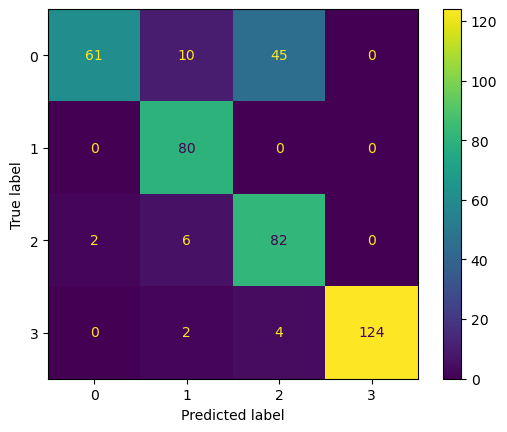

In [25]:
# collect n batches of images and display the confusion matrix for them.

class_names = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
n = 12 #<--you can change the number of batches selected.

image_batch, classes_batch = next(test_generator)

for batch in range(n):
    temp = next(test_generator)
    image_batch = np.concatenate((image_batch, temp[0]))
    classes_batch = np.concatenate((classes_batch, temp[1]))

classes_batch = classes_batch
y_predict = model.predict(image_batch)

#Confusion matrix for training data
cm = confusion_matrix(y_pred = [np.argmax(x) for x in y_predict], y_true = [np.argmax(x) for x in classes_batch])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [27]:
#This function will display a number of random images as well as the predictions for the type of weather.

def predict_one(model, num_images = None):  
    image_batch, classes_batch = next(test_generator)
    predicted_batch = model.predict(image_batch)
    for k in range(0,image_batch.shape[0] if num_images is None else num_images):
        image = image_batch[k]
        real_class = class_names[np.argmax(classes_batch[k])]
        predicted_class = class_names[np.argmax(predicted_batch[k])]
        value_predicted = predicted_batch[k]
        isTrue = (real_class == predicted_class)
        plt.figure(k)
        plt.title(str("Correct Prediction" if isTrue else "Incorrect Prediction") + ' - class: ' + real_class + ' - ' + 'predicted: ' + predicted_class + str(value_predicted))
        plt.axis('off')
        plt.savefig('./' + real_class + '_' + predicted_class + '_' + str(value_predicted) + '.png')
        plt.imshow(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


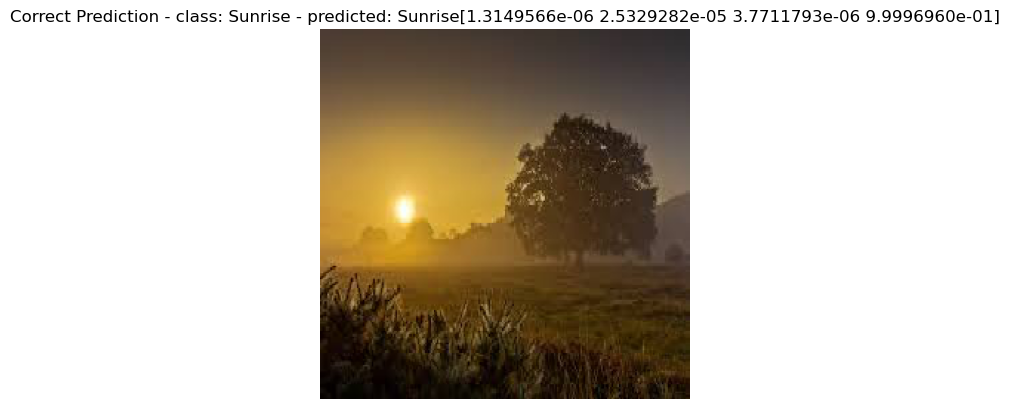

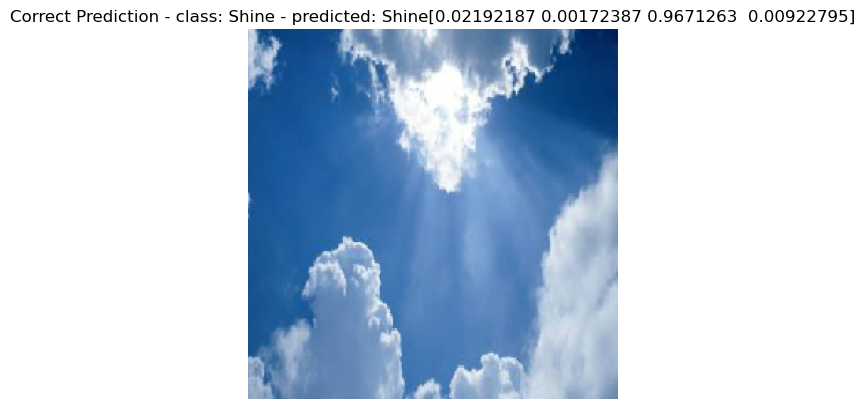

In [29]:
predict_one(model, 4) #<--you can show multiple pictures with this command. Just fill in the number you want to see.